In [21]:
import os, glob, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import collections
import cv2
import tqdm
from PIL import Image
import torch
import torchvision.models

import sklearn
import sklearn.metrics
from scipy.special import expit

In [22]:
import sys
sys.path.append('/home/users/jsoelter/Code/ChestImageAI/utils/')
sys.path.append('/home/users/jsoelter/Code/big_transfer/')

import data_loader, evaluations, model_setup

### Model Setup

In [23]:
model_dict =  dict(
    architecture =  'densenet121', 
    #architecture = 'BiT-M-R50x3',
    num_classes = 5,
    pretrained = '/home/users/jsoelter/models/chexpert/densenet/pain_lowres2/step',
    #pretrained = '/home/users/jsoelter/models/chexpert/fullmeta_503_consolidation/step00100.pt',
)

In [24]:
ledger = json.load(open(os.path.join(os.path.dirname(model_dict['pretrained']), 'train_ledger.json')))

model = model_setup.instantiate_model(**model_dict)
   
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Loaded pretraining weights from /home/users/jsoelter/models/chexpert/densenet/pain_lowres2/step10500.pt


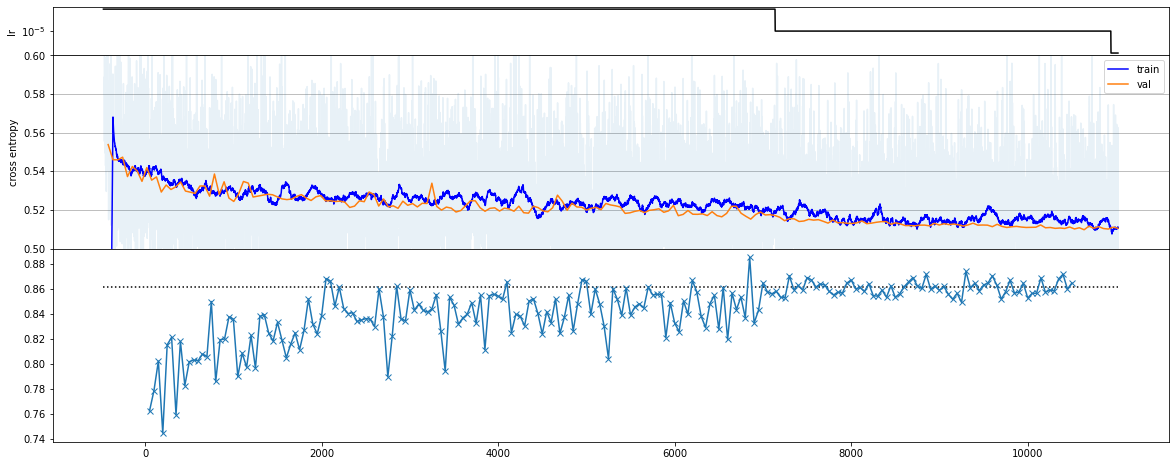

In [25]:
fig = plt.figure(figsize=(20,8)) 
gs = matplotlib.gridspec.GridSpec(3,1,height_ratios=(1,4,4), hspace=0)

ax = plt.subplot(gs[0])
plt.plot(ledger['lr'], 'k')
plt.xticks([])
plt.ylabel('lr')
plt.yscale('log')
#plt.xlim([0, 10000])


ax = plt.subplot(gs[1])
plt.plot(ledger['train_loss'], alpha=0.1) #, np.hstack([np.zeros(99), np.ones(100)/100]), mode = 'same'))
plt.plot(np.convolve(ledger['train_loss'], np.hstack([np.zeros(99), np.ones(100)/100]), mode = 'same'), color='b', label='train')
plt.plot(*np.array(ledger['internal']).T, '-', label='val')
#plt.yscale('log')
plt.ylim([0.5, 0.6])
plt.legend()
plt.grid()
#plt.yscale('log')
plt.ylabel('cross entropy')
plt.xticks([])


ax = plt.subplot(gs[2])
plt.plot(*np.array(ledger['external']).T, 'x-')
plt.hlines(np.array(ledger['external'])[-20:, 1].mean(), *plt.gca().get_xlim(), 'k', linestyles=':')

### Data Setup

In [26]:
data_setup = dict(
    include_meta = [],
    #include_meta = ['Sex', 'AP/PA', 'Frontal/Lateral'],
    label_value_map = {
       #0: 0.05,
       'nan': 0.1,
       -1.: 0.5,
       #1: 0.9
    },
    fill_hierachy = {
        #'Enlarged Cardiomediastinum': ['Cardiomegaly'],
        #'Consolidation': ['Pneumonia'],
        #'Lung Opacity': ['Edema', 'Pneumonia', 'Consolidation', 'Lung Lesion', 'Atelectasis']
    },
    labels = ['Cardiomegaly', 'Edema',  'Consolidation', 'Atelectasis', 'Pleural Effusion'],
    subset = {}, # Define subsetting of data
)

transforms = {
    'ToPILImage': {},
    'Resize': { #smaller edege mapped to x
        'size': 544
        #'size': 512
    },
    'RandomRotation': {
        'degrees': 5
    },
    'RandomCrop': {
        'size': (512, 512)
        #'size': (480, 480)
    },
    'ToTensor': {},
    'Normalize': {
        'mean': [0.485, 0.456, 0.406], 
        #'mean': (0.5, 0.5, 0.5),
        'std': [0.229, 0.224, 0.225]  
        #'std': (0.5, 0.5, 0.5)
    },
}

In [27]:
transforms = ledger['train_setup']['0']['transforms']

In [28]:
def transform_pipeline_from_dict(transform_list):
    ''' creates transfrom pipeline from list
    
        Example:
          [
            ('RandomRotation', {
                    'degrees': 5
            }),
            ('RandomCrop', {
                    'size': (480,480)
            }),
            ('ToTensor', {})
          ]
    '''    
    transform_objects = [data_loader.create_transform(k, v) for k, v in transform_list.items()]
    return torchvision.transforms.Compose(transform_objects)


In [31]:
preprocess = data_loader.transform_pipeline_from_dict(transforms)

data = data_loader.ChexpertData('CheXpert-v1.0/train.csv', transform=preprocess, **data_setup)
internal_valid_data, train_data = torch.utils.data.random_split(data, [1000, len(data)-1000], generator=torch.Generator().manual_seed(42))
external_valid_data = data_loader.ChexpertData('CheXpert-v1.0/valid.csv', 
    transform=preprocess, include_meta=data_setup['include_meta'], labels = data_setup['labels'])

Removed 0 entries
Removed 0 entries


In [32]:
computational_setup = dict(
    num_workers = 8,
    batch_size = 16
)

train_loader = torch.utils.data.DataLoader(train_data, **computational_setup)
valid_int_loader = torch.utils.data.DataLoader(internal_valid_data, **computational_setup)
valid_ext_loader = torch.utils.data.DataLoader(external_valid_data, **computational_setup)

### Benchmark

In [33]:
external_pred_ens, external_tar = evaluations.batch_prediction(model, valid_ext_loader, tta_ensemble = 1, device=device)
external_pred = evaluations.ensemble_mean(external_pred_ens)

In [34]:
to_predict = [
    ('Atelectasis', (0.825, 0.903)), 
    ('Cardiomegaly', (0.855, 0.870)), 
    ('Consolidation', (0.937, 0.933)), 
    ('Edema', (0.930, 0.944)), 
    ('Pleural Effusion',  (0.923, 0.917)), 
    ('AP/PA', 0), 
    ('Frontal/Lateral', 0), 
    ('Sex', 0)
]

for l, ref_score in to_predict:
    try:
        i = external_valid_data.targets.index(l)
        include = external_tar[:,i]>=0
        s = sklearn.metrics.roc_auc_score(external_tar[include,i], external_pred[include, i])
        print(f'{l:<18}{s:.3f}  vs. {ref_score}')
    except:
        continue

Atelectasis       0.809  vs. (0.825, 0.903)
Cardiomegaly      0.852  vs. (0.855, 0.87)
Consolidation     0.918  vs. (0.937, 0.933)
Edema             0.932  vs. (0.93, 0.944)
Pleural Effusion  0.927  vs. (0.923, 0.917)


In [35]:
from scipy.special import expit

s_tot = 0
tars, preds = [], []
for l, ref_score in to_predict[:-3]:
    i = external_valid_data.targets.index(l)
    include = external_tar[:,i]>=0
    
    tar_by_study = pd.DataFrame(external_valid_data.meta_df.Path.str.split('/').str.get(-3))
    pred_by_study = tar_by_study.copy()

    tar_by_study['target'] = external_tar[include, i]
    tar = tar_by_study.groupby('Path').target.mean()

    pred_by_study['pred'] = expit(external_pred[include, i])
    pred = (pred_by_study.groupby('Path').pred).mean()
    
    s = sklearn.metrics.roc_auc_score(tar, pred)
    
    tars.append(tar)
    preds.append(pred)
    s_tot += s
    
    print(f'{l:<18}{s:.3f}  vs. {ref_score}')
total_auc = sklearn.metrics.roc_auc_score(np.hstack(tar), np.hstack(pred))
print(f'Average AUC: {s_tot/5:.3f}')
print(f'Full AUC:    {total_auc:.3f}')

Atelectasis       0.798  vs. (0.825, 0.903)
Cardiomegaly      0.851  vs. (0.855, 0.87)
Consolidation     0.906  vs. (0.937, 0.933)
Edema             0.938  vs. (0.93, 0.944)
Pleural Effusion  0.928  vs. (0.923, 0.917)
Average AUC: 0.884
Full AUC:    0.928


### Compare prediction distributions

#### by target value

In [36]:
internal_pred_ens, internal_tar = evaluations.batch_prediction(model, valid_int_loader, max_batch=50, tta_ensemble = 1, device=device)
internal_pred = evaluations.ensemble_mean(internal_pred_ens)

train_pred_ens, train_tar = evaluations.batch_prediction(model, train_loader, max_batch=50, tta_ensemble = 1, device=device)
train_pred = evaluations.ensemble_mean(train_pred_ens)

In [37]:
selection =  ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

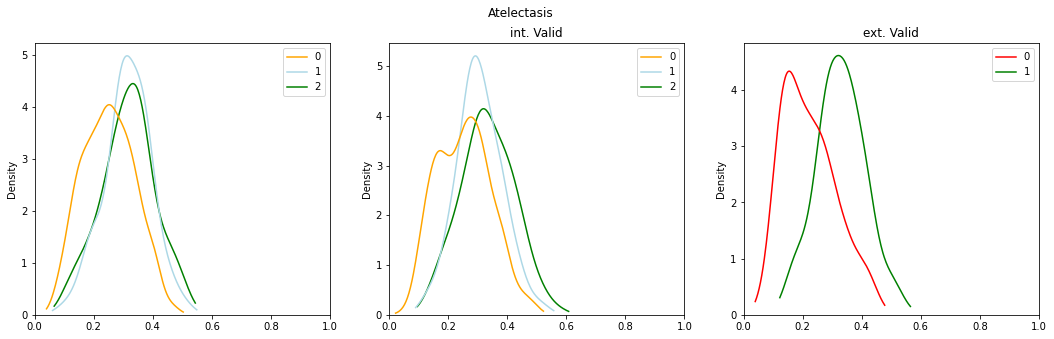

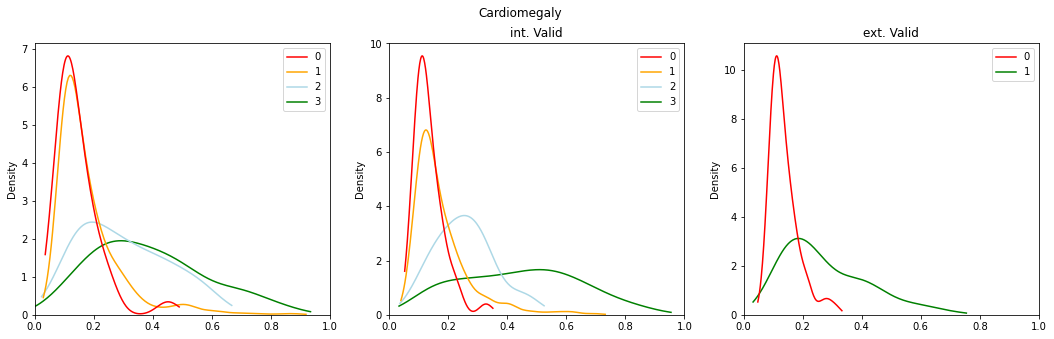

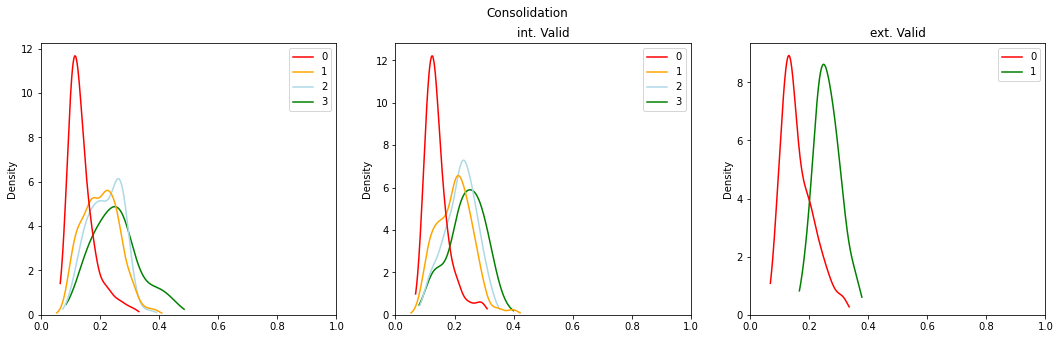

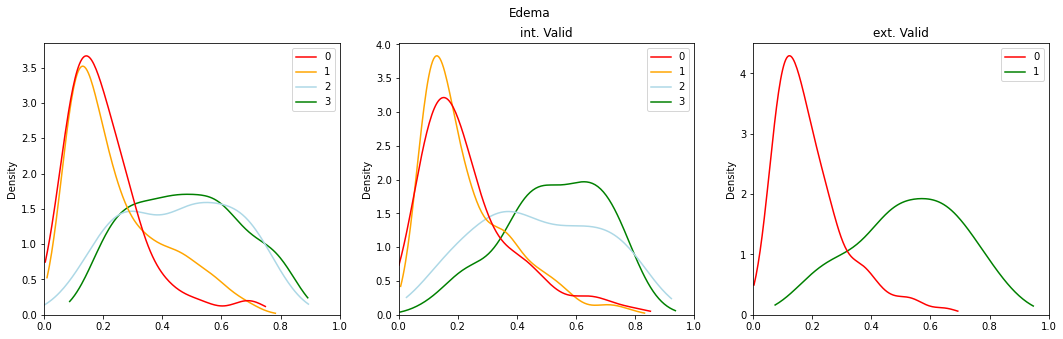

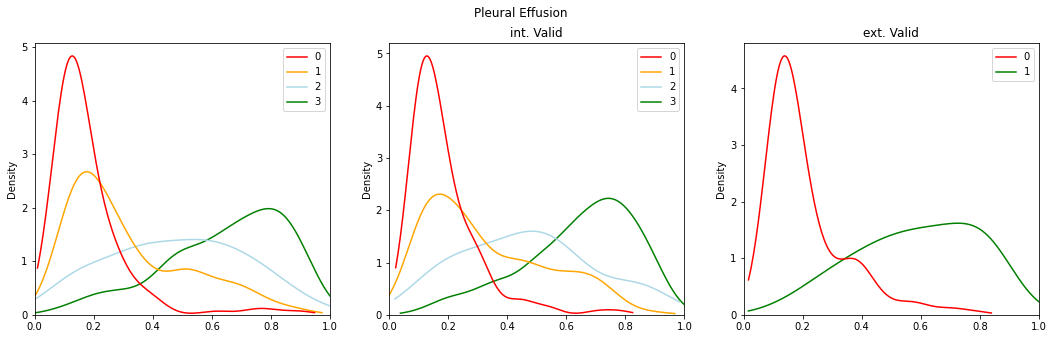

In [38]:
values = [0,0.1,0.5,1]
pallete = ['r', 'orange', 'lightblue', 'green']
common_norm = False

def myplot(tar, p):
    split = [p[tar == m] for m in values]
    msk = [len(d)>10 for d in split]
    sns.kdeplot(
        data=[s for (s, m) in zip(split, msk) if m],
        palette=[s for (s, m) in zip(pallete, msk) if m],
        common_norm=common_norm, cut=True)
    plt.xlim([0,1])

for l in selection:
    col = np.where(np.array(data.targets) == l)[0]

    fig = plt.figure(figsize=(18,5))
    plt.suptitle(l)
    
    ax = plt.subplot(131)
    myplot(train_tar[:, col], expit(train_pred[:, col]))

    ax = plt.subplot(132)
    myplot(internal_tar[:, col], expit(internal_pred[:, col]))
    ax.set_title('int. Valid')
    
    ax = plt.subplot(133)
    myplot(external_tar[:, col], expit(external_pred[:, col]))
    ax.set_title('ext. Valid')

#### by meta data

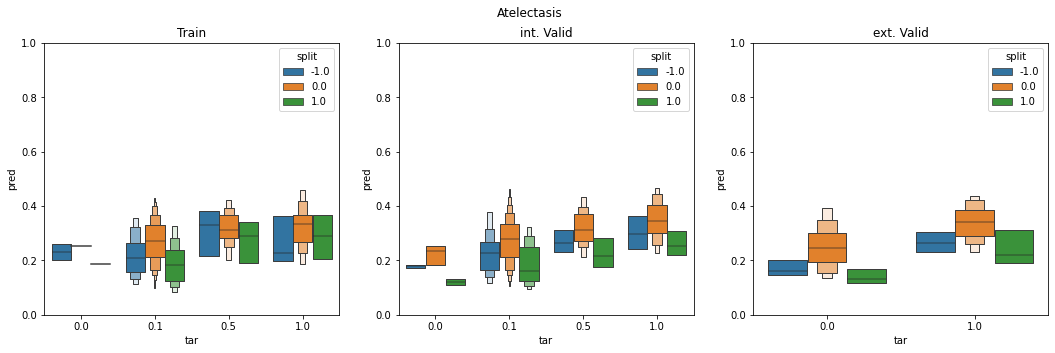

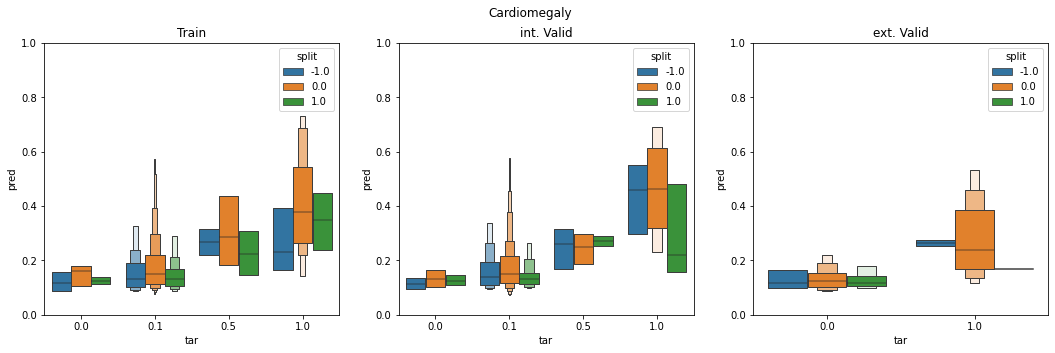

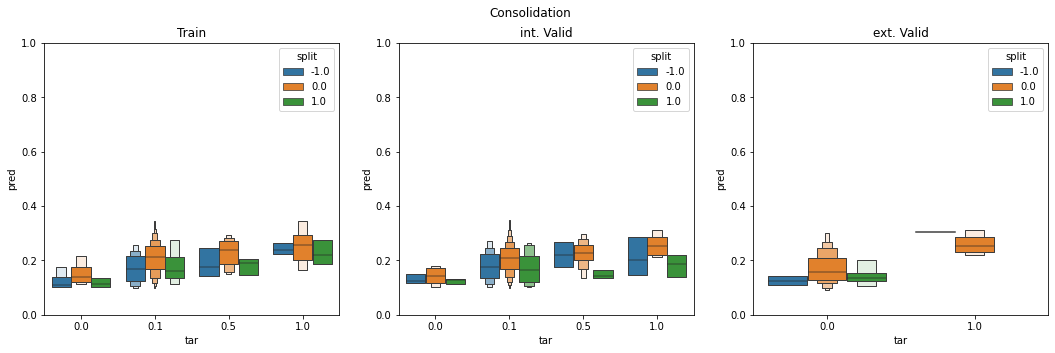

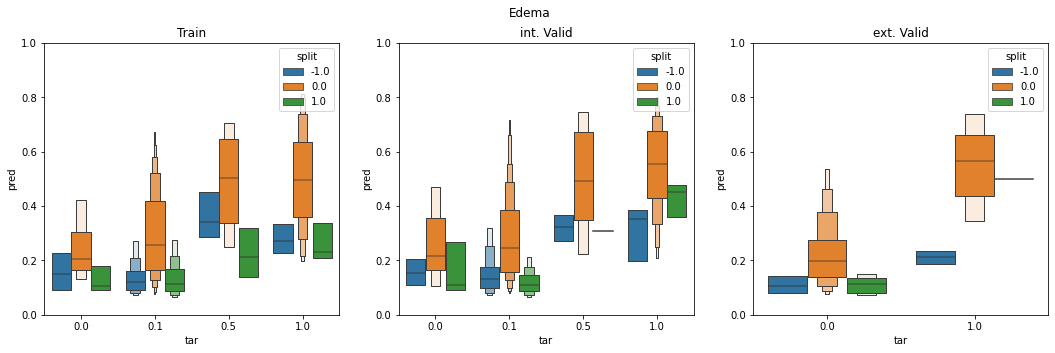

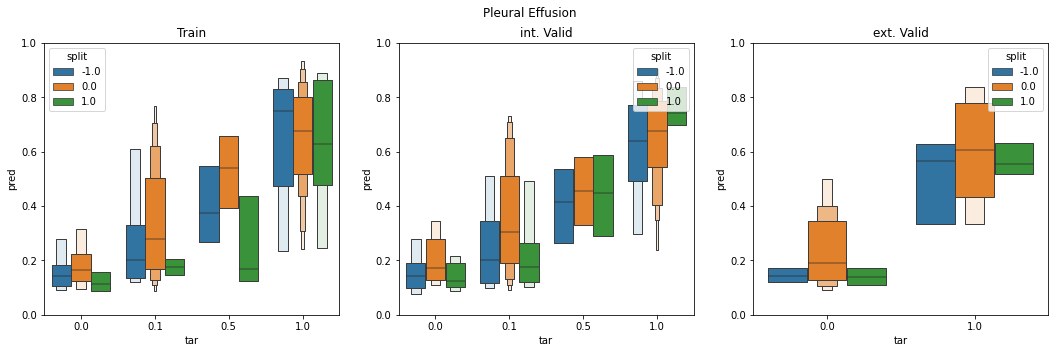

In [39]:
common_norm = False
split_by = 'AP/PA'

def myplot(tar, pred, dataset):
    p = expit(pred)
    if hasattr(dataset, 'dataset'):
        mcol = dataset.dataset.meta_df.loc[dataset.indices][:(len(p))][split_by]
    else:
        mcol = dataset.meta_df[:(len(p))][split_by]
    temp = pd.DataFrame(np.array([p.squeeze(), mcol, tar.squeeze()]).T, columns=['pred', 'split', 'tar'])
    sns.boxenplot(data=temp, x='tar', y='pred', hue='split', showfliers=False)
    plt.ylim((0,1))

for l in selection:
    col = np.where(np.array(data.targets) == l)[0]
    
    fig = plt.figure(figsize=(18,5))
    plt.suptitle(l)

    ax = plt.subplot(131)
    myplot(train_tar[:, col], train_pred[:, col], train_data)
    ax.set_title('Train')

    ax = plt.subplot(132)
    myplot(internal_tar[:, col], internal_pred[:, col], internal_valid_data)
    ax.set_title('int. Valid')

    ax = plt.subplot(133)
    myplot(external_tar[:, col], external_pred[:, col], external_valid_data)
    ax.set_title('ext. Valid')
    

## Explainability

In [40]:
import gradcam
#gradcam_model = gradcam.GradCAM(model, model._modules['head']._modules['relu'])
gradcam_model = gradcam.GradCAM(model, model._modules['features']._modules['norm5'])

In [41]:
label = 'Consolidation' #'Atelectasis' #'Sex' #'Support Devices' #'Consolidation' # #AP/PA' #'Cardiomegaly' # #''Atelectasis' #Sex #'Frontal/Lateral' #'Support Devices' #'Edema'
il = external_valid_data.targets.index(label)

error = np.abs(external_tar[:,il] - expit(external_pred[:, il]))
CP = external_tar[:,il]>0
CN = external_tar[:,il]==0

selection_mask = np.array([np.where(l == np.array(data.targets))[0] for l in selection]).squeeze()

In [42]:
def explain(image_ids):
    for i in image_ids:
        plt.figure(figsize=(20, 4.5))
        img = external_valid_data[i][0]

        plt.subplot(141)
        plt.barh(range(len(selection)), external_tar[i,selection_mask], alpha=1, ec='g', linewidth=3, fc='none')
        plt.barh(range(len(selection)), expit(external_pred[i,selection_mask]), alpha=0.3, 
                 color=['g' if t >0 else 'r' for t in external_tar[i,selection_mask]]
        )
        _ = plt.yticks(range(len(selection)), selection)
        plt.xlim((0,1.1))

        plt.subplot(142)
        plt.imshow(img[0], cmap=plt.cm.viridis)
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(img[0], cmap=plt.cm.bone)
        plt.axis('off')

        #labels = [external_valid_data.targets[q] for q in np.where(external_tar[i,:]>0.5)[0]]
        #plt.title('\n'.join(labels))

        plt.subplot(144)
        mask, _ = gradcam_model(img.unsqueeze(0).to(device),  class_idx=il)
        heatmap, result = gradcam.utils.visualize_cam(mask, img[0])
        plt.imshow((result.T.numpy().swapaxes(0,1)+1)/2) #, cmap=plt.cm.bone)
        plt.axis('off')

### TP

/home/users/jsoelter/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


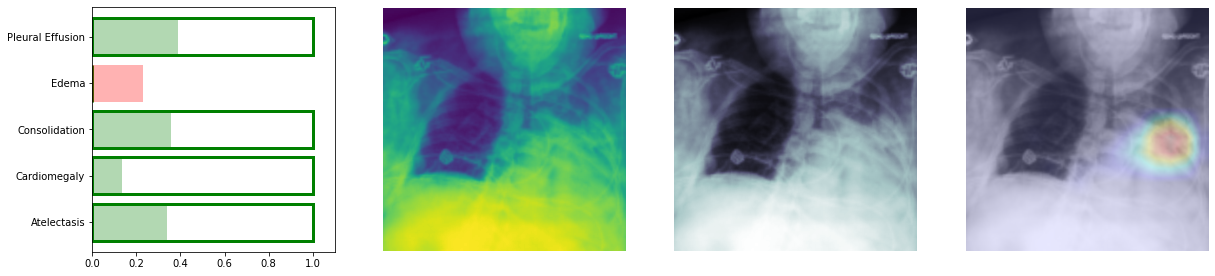

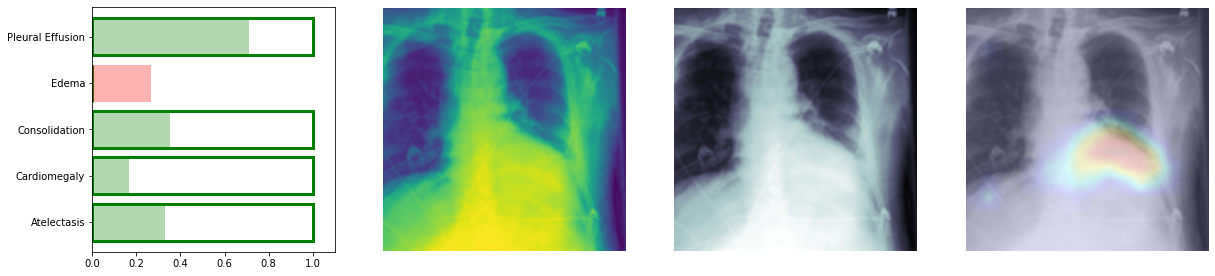

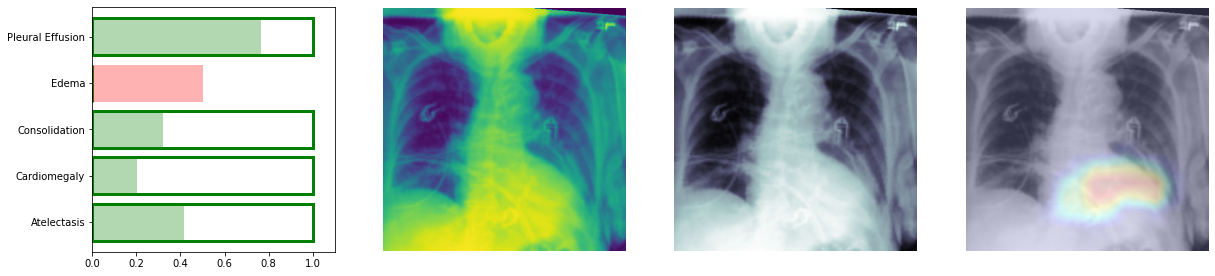

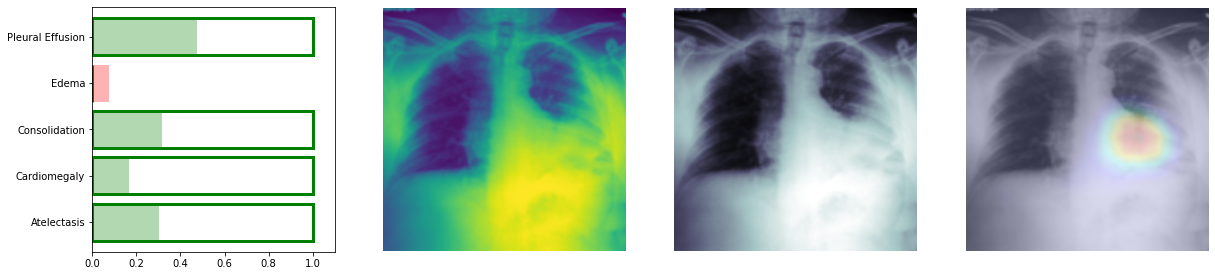

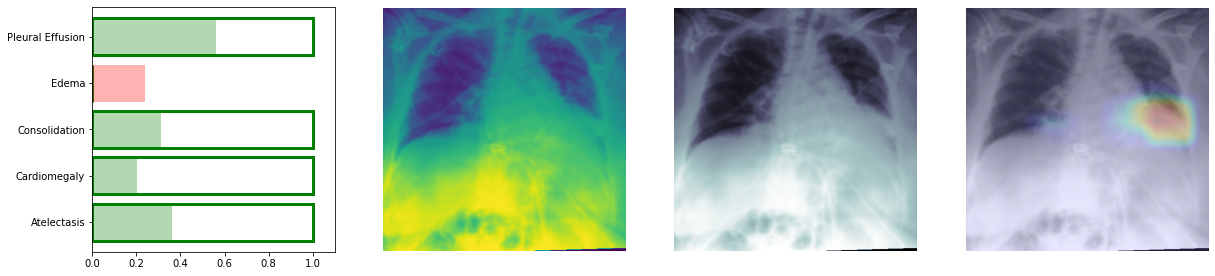

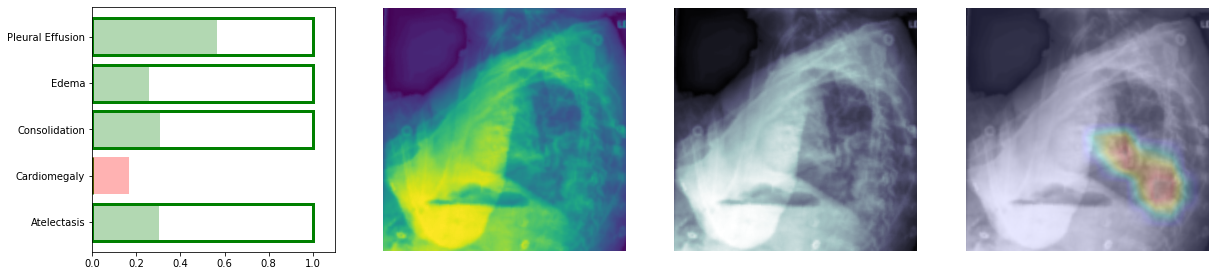

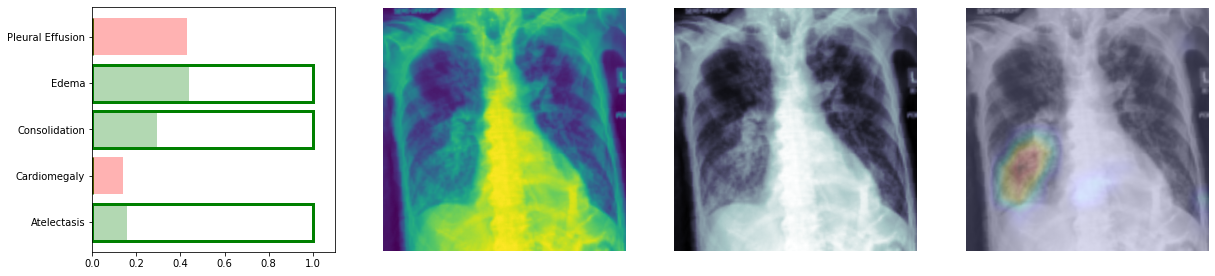

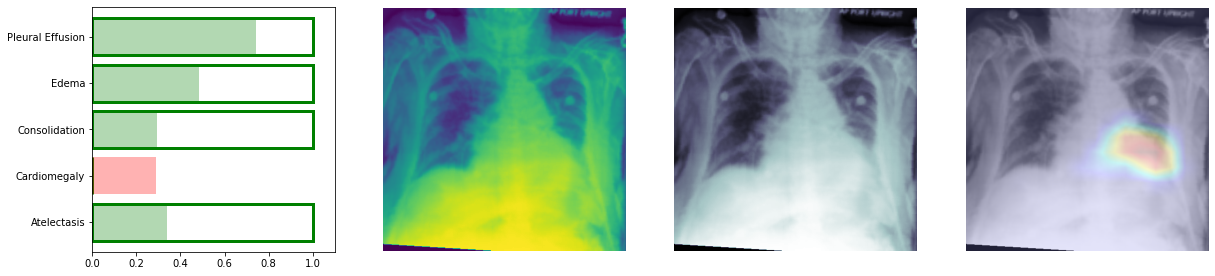

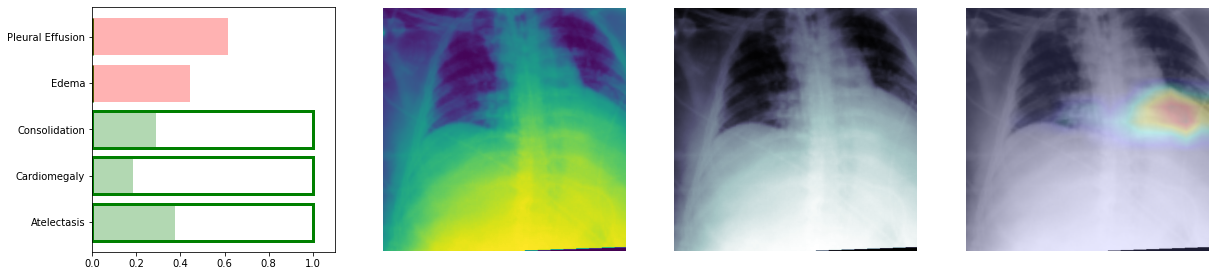

In [43]:
# Best CP prediction
explain(np.argsort(error*CP)[-CP.sum():][:9])

### FN

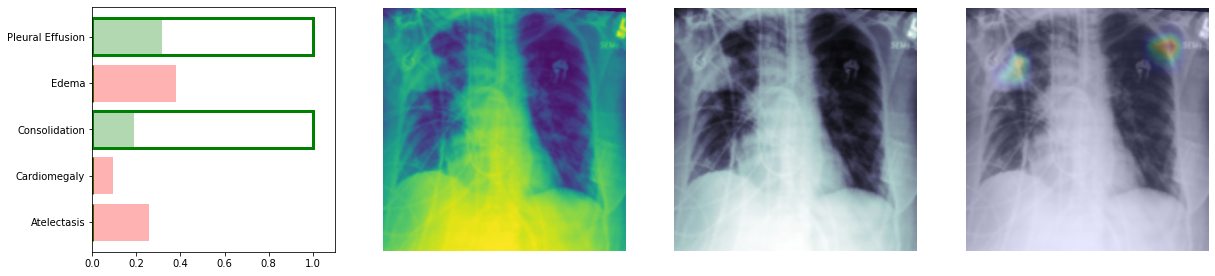

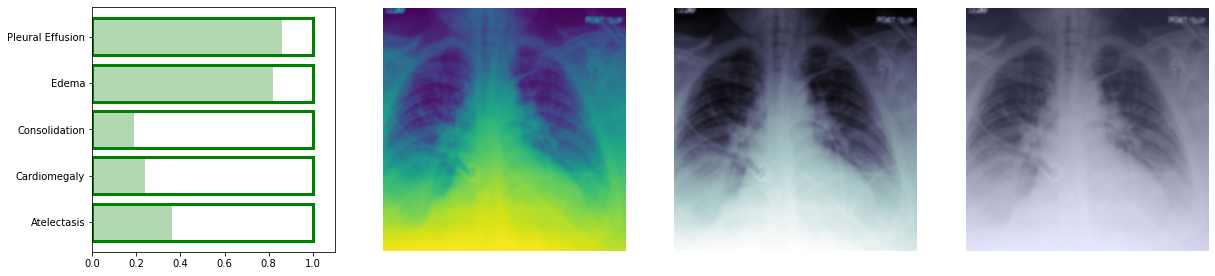

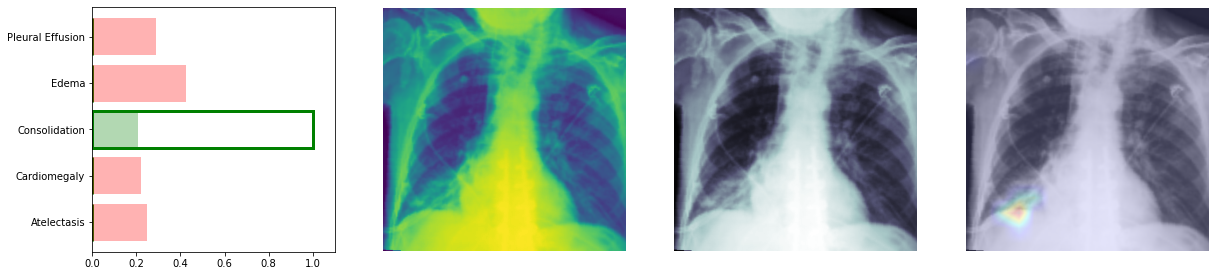

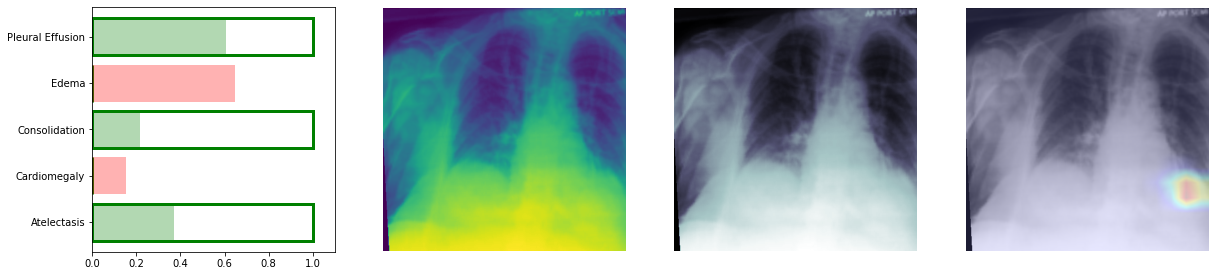

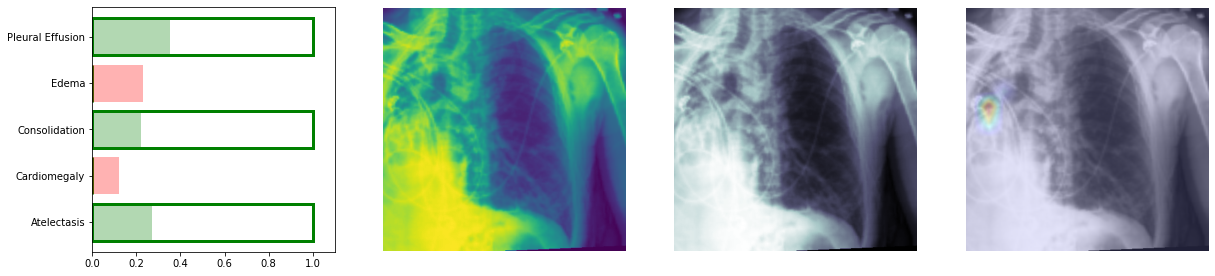

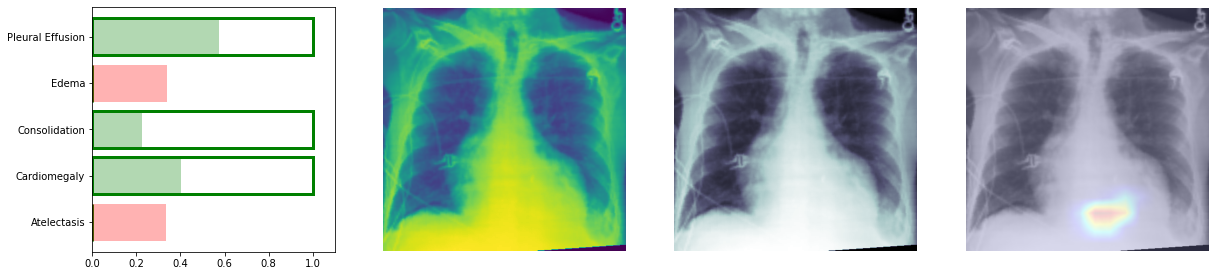

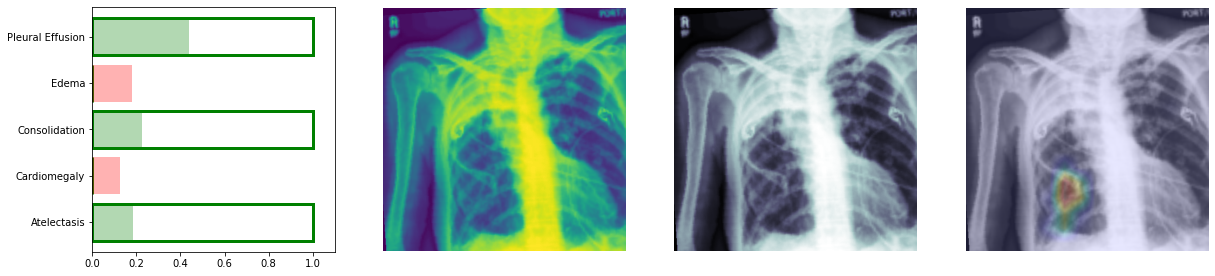

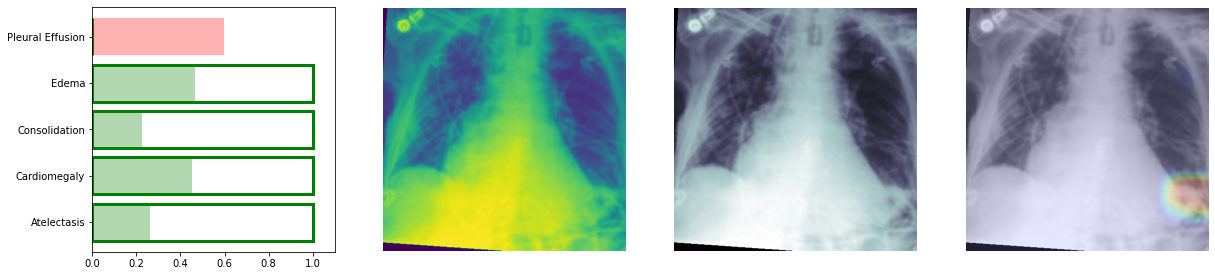

In [44]:
# Worst CP prediction
explain(np.argsort(error*CP)[-CP.sum():][-1:-9:-1])

### False Positive

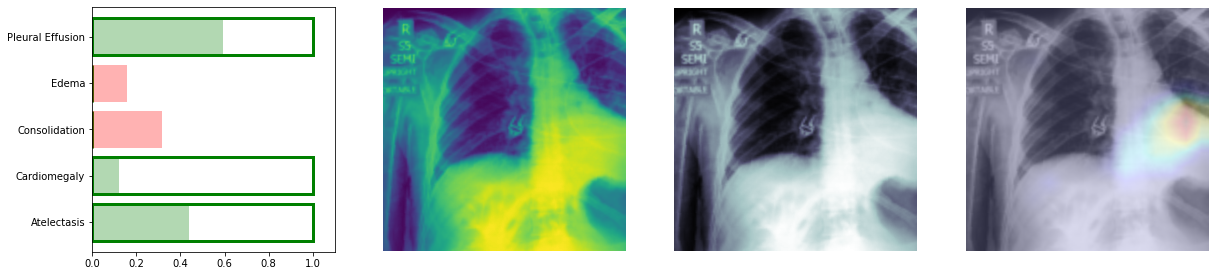

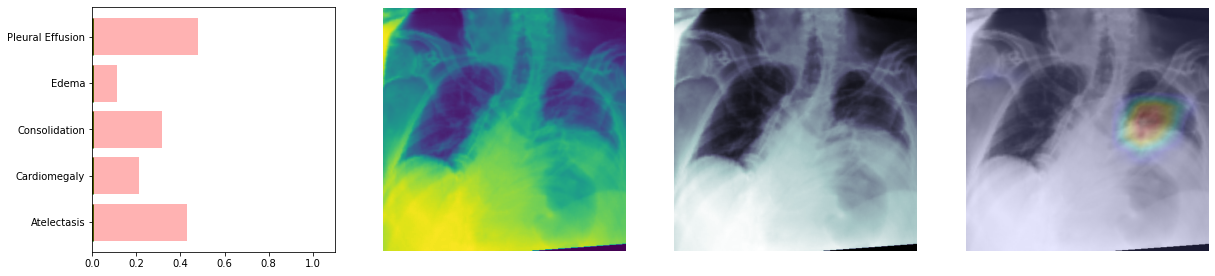

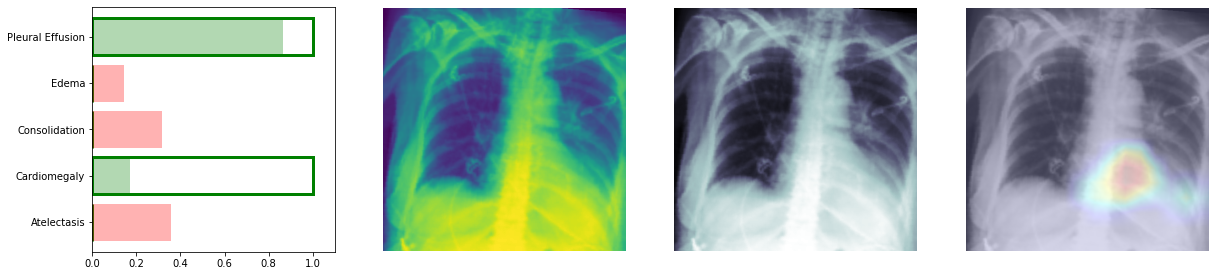

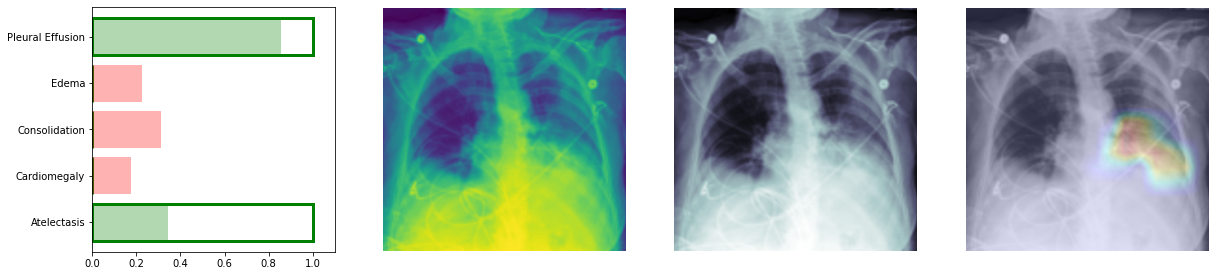

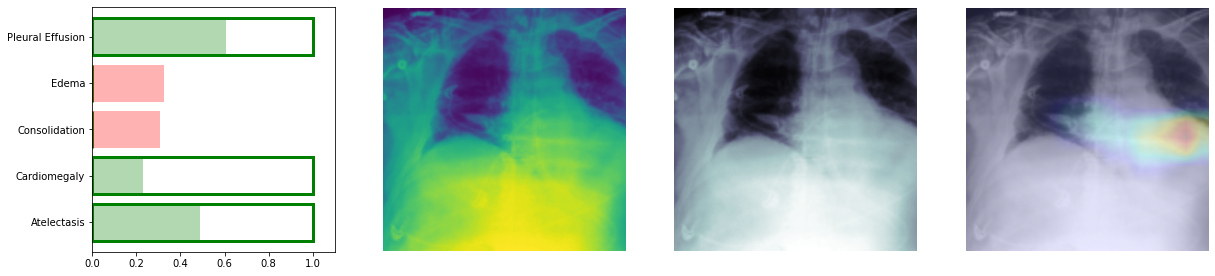

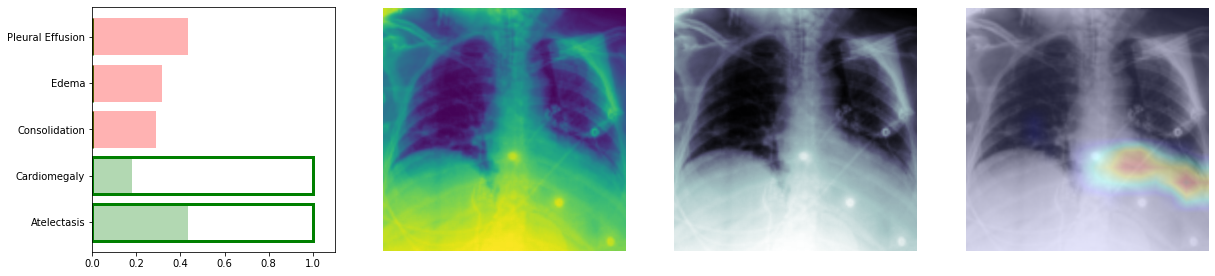

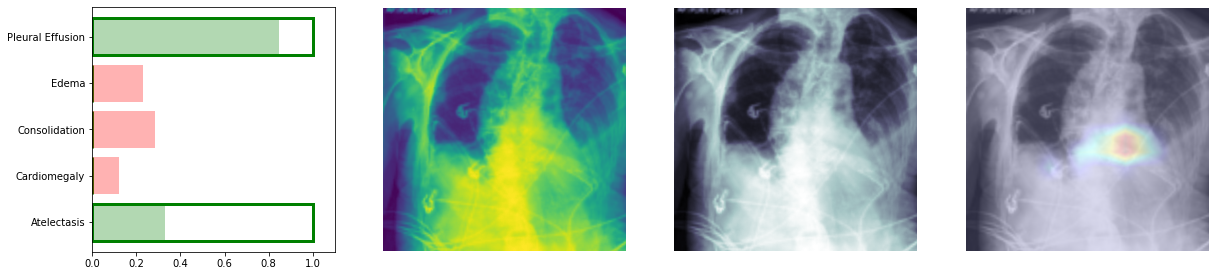

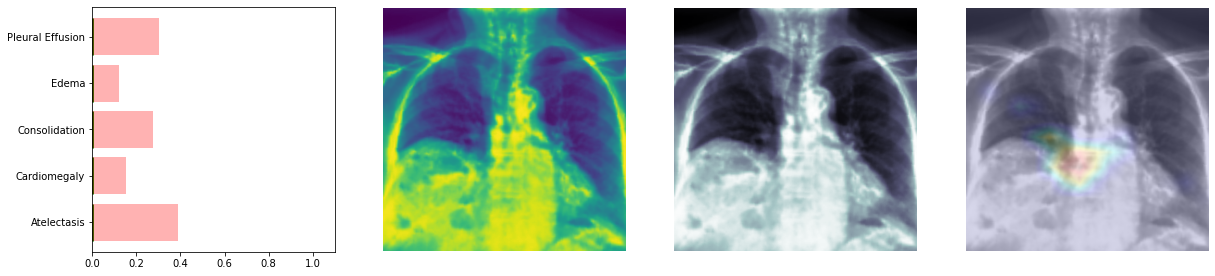

In [45]:
# Worst CN prediction
explain(np.argsort(error*CN)[-CN.sum():][-1:-9:-1])

### TN

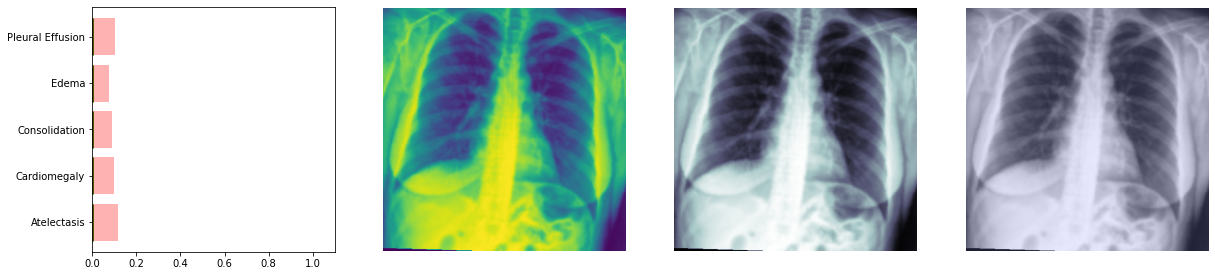

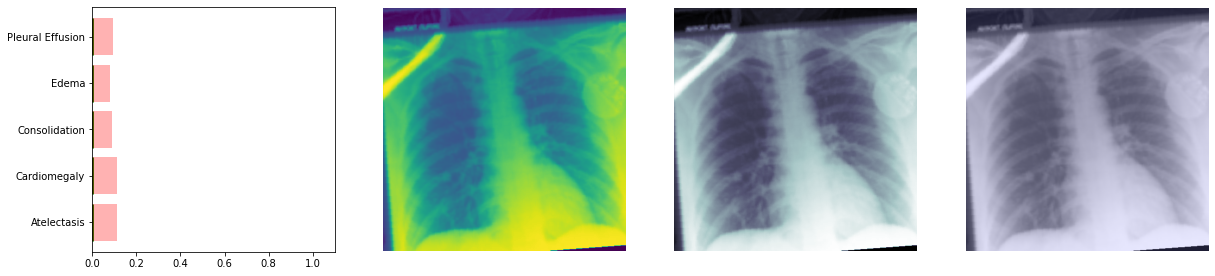

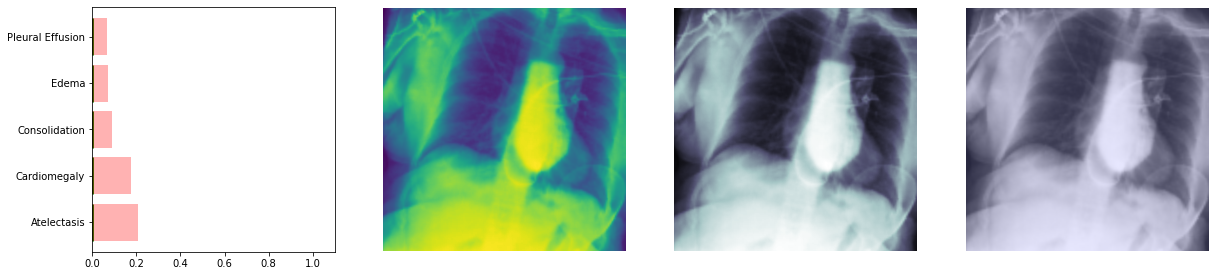

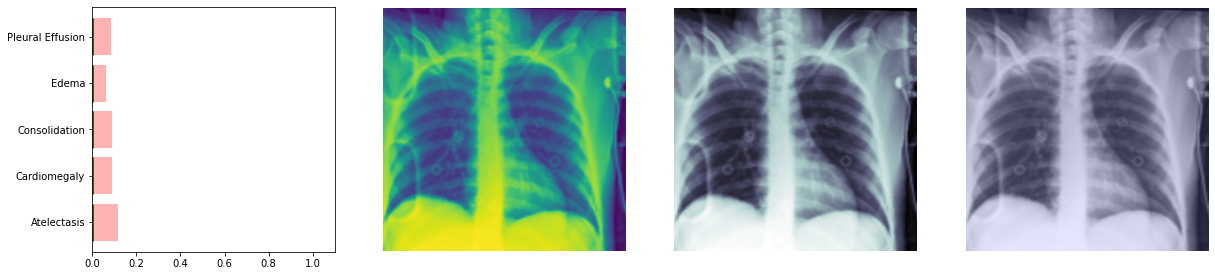

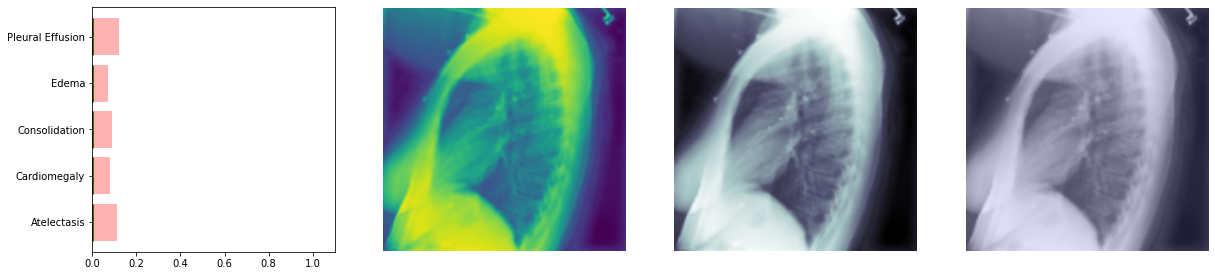

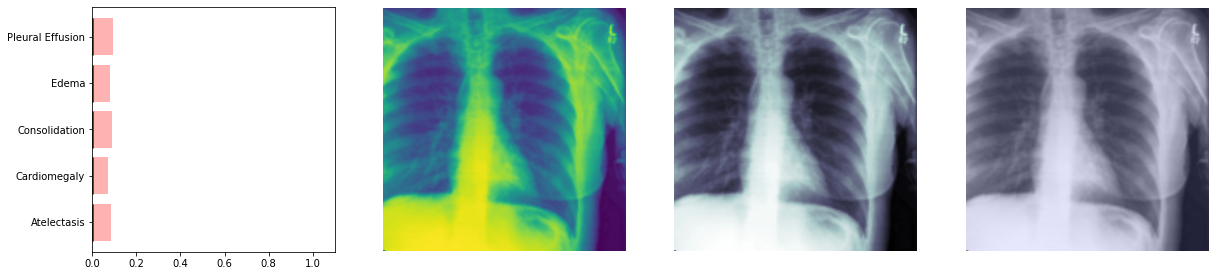

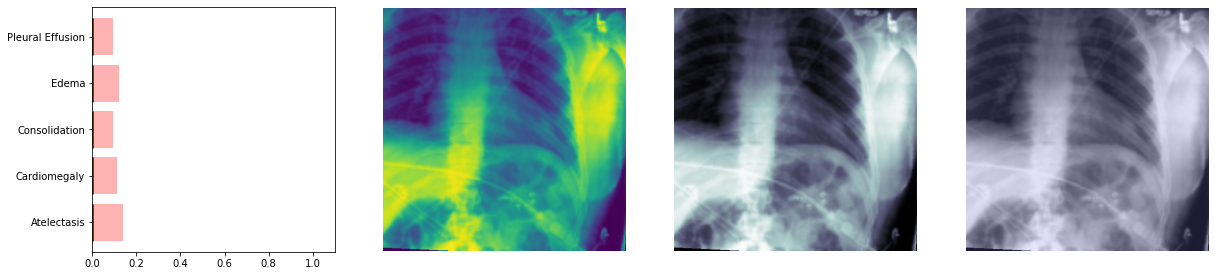

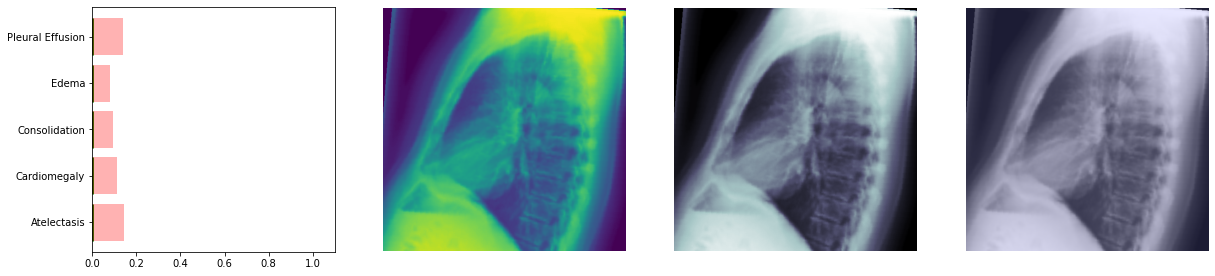

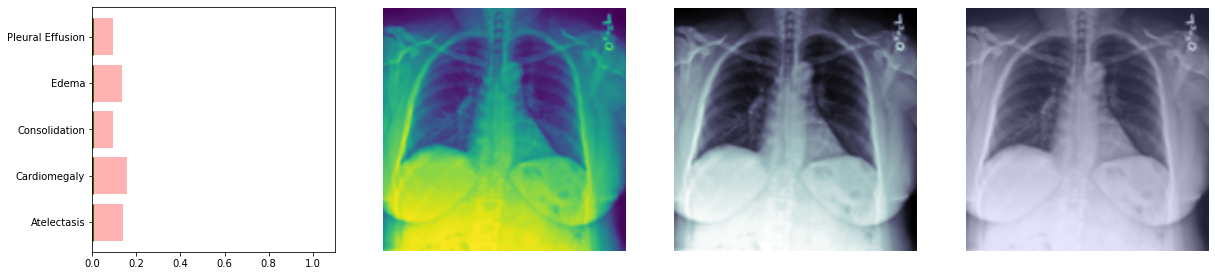

In [46]:
explain(np.argsort(error*CN)[-CN.sum():][:9])

In [47]:
tar = external_tar[:, selection_mask]
pred = expit(external_pred[:, selection_mask])
t = pd.DataFrame(tar, columns=selection)
pred_col = [s+'_pred' for s in selection]
p = pd.DataFrame(pred, columns=pred_col)

mean_pred = pd.concat([t,p], axis=1) #.groupby(['Atelectasis', 'Consolidation'])['Atelectasis_pred', 'Consolidation_pred'].mean()
#mean_pred = mean_pred[mean_pred[('Atelectasis_pred', 'count')]>3]

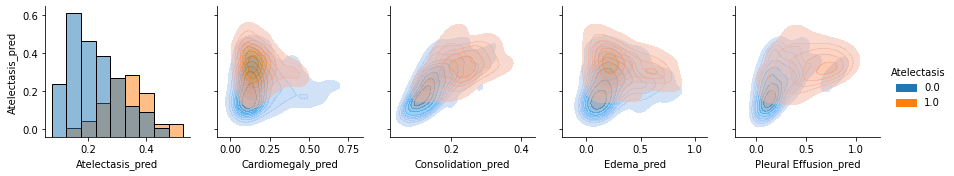

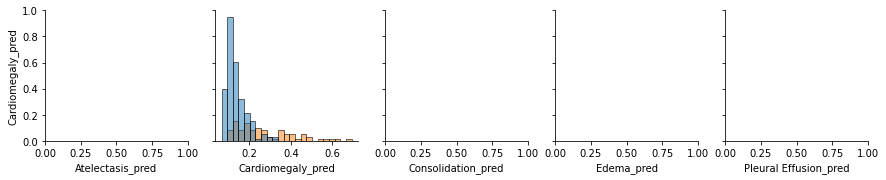

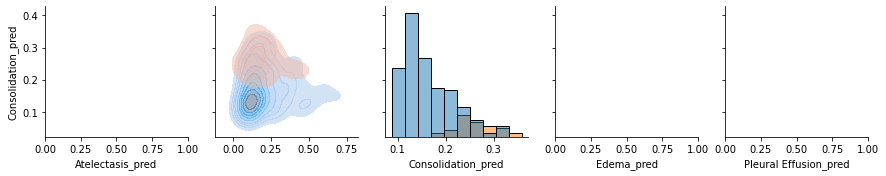

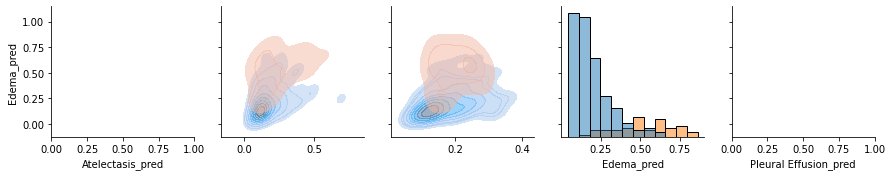

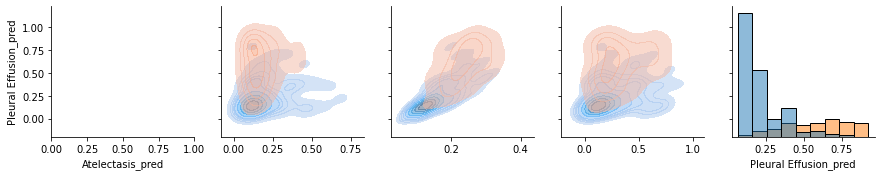

In [48]:
for y in selection:
    x_vars = selection
    g = sns.PairGrid(pd.concat([t[y], p], axis=1), hue=y, x_vars=[x + '_pred' for x in  x_vars], y_vars=[y + '_pred'])
    g.map_diag(sns.histplot, color=".3")
    try:
        g.map_upper(sns.kdeplot, alpha=0.5, fill=True)
        g.add_legend()
    except:
        pass

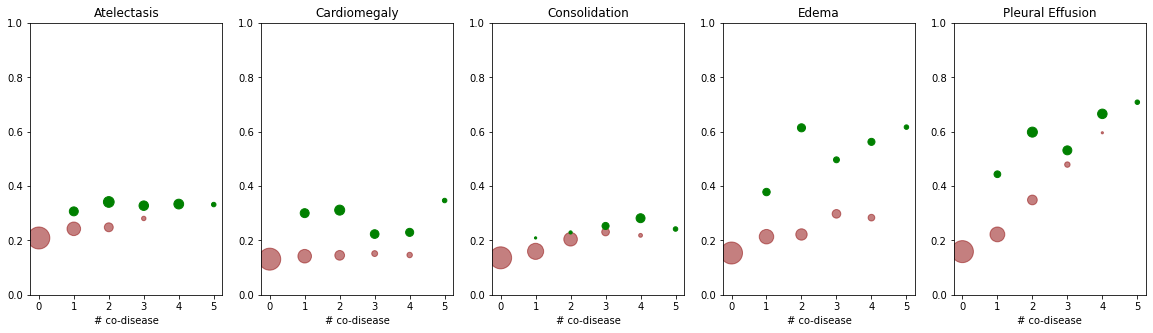

In [49]:
a = pd.concat([t, p, pd.DataFrame(t.sum(1), columns=['disease_count'])], axis=1)

plt.figure(figsize=(20,5))
for ix, dd in enumerate(selection):
    plt.subplot(1, len(selection), ix+1)
    aa = a.groupby([dd, 'disease_count'])[dd+'_pred'].agg(['mean', 'count'])
    tp = aa.unstack(dd)
    plt.scatter(tp.index, tp[('mean', 0)], s=tp[('count', 0)]*5, color='darkred', alpha=0.5)
    plt.scatter(tp.index, tp[('mean', 1)], s=tp[('count', 1)]*5, color='g')
    plt.xlabel('# co-disease')
    plt.ylim([0,1])
    plt.title(dd)